# <span style="color:green"> Numerical Simulation Laboratory (NSL) </span>
## <span style="color:blue">  Numerical exercises 4</span>

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import math
import matplotlib.cm as cm
from scipy.optimize import curve_fit
plt.rcParams.update({
    'font.family':'cmr10',
    'mathtext.fontset': 'cm',
    'axes.formatter.use_mathtext': True,
    'axes.axisbelow': True,
    'figure.figsize': [10.0, 5.0],
    'axes.labelsize': 15,
    'xtick.labelsize': 15,
    'ytick.labelsize': 15,
    'font.size':15
})

### Exercise 04.1

In Statistical Mechanics the Maxwell–Boltzmann distribution (<a href="https://en.wikipedia.org/wiki/Maxwell%E2%80%93Boltzmann_distribution" target="_blank">Link Wikipedia</a>) is a probability distribution used for describing particle speeds in idealized gases. However, rarefied gases at ordinary temperatures behave very nearly like an ideal gas and the Maxwell–Boltzmann speed distribution is an excellent approximation for such gases. For a 3D system its formula is:
$$p(v,T) = \left( \frac{m}{2\pi k_B T} \right)^{3/2} 4\pi v^2 e^{-\frac{m v^2}{2 k_B T}}$$

By using LJ reduced units (Lenght: $\sigma$; Energy: $\epsilon$; Mass: the mass, $m$, of the particles; Temperature: $\epsilon/k_B$; velocity: $\sqrt{\epsilon/m}$) its form becomes:
$$p(v^*,T^*) = \frac{1}{(2\pi T^*)^{3/2}} 4\pi (v^*)^2 e^{-\frac{(v^*)^2}{2 T^*}}$$

The NSL_SIMULATOR code already computes the total (internal) energy per particle, $E/N$, the potential energy per particle, $U/N$, the kinetic energy per particle, $K/N$, the temperature, $T$, and the pressure, $P$.

Include the calculation of the Maxwell–Boltzmann distribution, $p(v^*,T^*)$, inside your Molecular Dynamics code by using data blocking to obtain single block averages, progressive average values and progressive uncertainties for $p(v^*,T^*)$.

Remember that, the Maxwell–Boltzmann distribution, $p(v^*,T^*)$, can be approximately computed as a **normalized histogram** on an appropriate interval $\left[ 0, v_{max}\right]$ and chosing the number of bins into which you want to divide this interval.

#### Soluzione 04.1
___
Per includere nel codice di Dinamica Molecolare il calcolo della distribuzione di Maxwell-Boltzmann $p(v^*,T^*)$ ho modificato la classe ```System``` in diversi punti:
- innanzitutto nel metodo ```initialize_properties()``` ho implementato la creazione dei bin per salvare la probabilità delle velocità del sistema. 
- in seguito nel metodo ```measure()``` ho calcolato il modulo della velocità di ciascuna particella e ho incrementato il contatore dell'indice del vettore ```_measurement``` corrispondente ```(_index_pofv + int(v/_bin_size_v))```. Bisogna stare attenti che se v/_bins_size_v è maggiore nel numero di bin la velocità cadrebbe fuori dall'istogramma. Per risolvere questo problema ho deciso di mettere tutte queste velocità nell'ultimo bin; una scelta altrenativa potrebbe essere quella di eliminare quei valori.
- per completare il calcolo della densità di probabilità aggiungiamo nel metodo ```average()``` il calcolo della media a blocchi per ogni bin e il corrispondente errore. Salviamo l'indice del blocco, la velocità corrispondente al bin, il valor medio del numero di elementi in quel bin corrispondenti a quella velocità e l'errore.
- in ultimo ho settato la velocità massima, per farlo inizialmente ho plottato la distribuzione delle velocità che ottenevo lasciando il valore impostato $(4*temp)$, poi vedendno che dopo $v=5$ la distribuzione si appiattiva ho impostato $v_{max} = 5$. Inoltre per calcolare più accuratamnete il valore di $v_{max}$ ho fatto un calcolo analitico considerando $v_{max} \simeq <v> +3\sigma$.
Il valor medio lo calcolo come:

$$ \langle v \rangle = \int_0^{\infty} dv^*  v^* p(v^*,T^*) = 1.6 \sqrt{T^*}$$

La $\sigma$ come:

$$ \sigma^2 = \langle v^2 \rangle - \langle v \rangle^2 $$

dove $\langle v^2 \rangle$ deriva dall'uguaglianza dell'energia cinetica con l'equipartizione dell'energia:
 $$\frac{{v^*}^2}{2} = \frac{3 T^*}{2}$$

Quindi:
$$ v_{max} = (1.6 + 3* \sqrt{ 3-(1.6)^2 } ) \sqrt{T^*} = 3.6 \sqrt{T^*} $$
Poi in realtà nella simulazione ho messo $v_{max} = 5 \sqrt{T^*}$ per ottenere una distribuzione migliore.

Bisogna poi normalizzare la distribuzione ottenuta in modo da poterla confrontare con la distribuzione di Maxwell-Boltzman delle velocità:
$$p(v^*,T^*) = \frac{1}{(2\pi T^*)^{3/2}} 4\pi (v^*)^2 e^{-\frac{(v^*)^2}{2 T^*}}$$

Per normalizzare dividiamo le ordinate per ` _n_part*_bin_size_v` , che è un'approssimazione dell'area della distribuzione ottenuta. 


``` c++
 //creazione dell'istogramma
 if(_measure_pofv) {
    for(int i = 0; i<_npart; i++){
      double v = sqrt( dot( _particle(i).getvelocity() , _particle(i).getvelocity() ));
      if(int(v/_bin_size_v) < _n_bins_v){
        _measurement(_index_pofv + int(v/_bin_size_v))++;
      } else {
        _measurement(_index_pofv +_n_bins_v-1)++;
      }
    }
  }
```

### Exercise 04.2

By means of your upgraded code, <span style="color:red">perform MD simulations via a Lennard-Jones model</span> ( e.g. Argon parameters: $\sigma = 0.34$ nm, $\epsilon/k_B = 120$ K, $m=39.948$ amu) in the following conditions:
- gas phase: $\rho^\star = 0.05$, $T^\star \sim  2.0$ (cut-off radius: $r_c = 5.0$)

starting from a <span style="color:red">**very low entropic** initial configuration</span>:
1. initial **particle positions**: <span style="color:red">fcc crystal occupying half of the simulation box in each dimension</span>
2. initial **velocity distribution**:  $p_\delta(v^*,T^*) = \delta\left( v^* - v_{T^*}\right)$ where $v_{T^*}$ is suitably connected to $T^*$. For example, this condition could be obtained by imposing that every particle has an initial velocity $\pm v_{T^*}$ for **only one** of its velocity components: $v_x$, $v_y$, $v_z$.

The goal is to show that, by evolving such initial condition via a Molecular Dynamics simulation, the velocity distribution tends to approximate the Maxwell–Boltzmann distribution.

- **Produce some pictures that show this convergence**
- The evolution of the system moves towards the increasing of entropy (more homeogeneous configuration of particles)? What would you find by changing the direction of time? Comment on these aspects in your jupyter-notebook

**Note that** the MD simulation will conserve the total energy; thus the kinetic energy and the temperature are not constant of motion ... the comparison should be done with $p(v^*,T^*_{\rm eff})$ where $T^*_{\rm eff}$ is the effective temperature obtained once the system has been equilibrated.

#### Soluzione 04.2
___
Facciamo evolvere il sistema partendo da uno stato a bassa entropia, cioè da una configurazione di un cristallo FCC con velocità distribuite con una probabilità: $p_\delta(v^*,T^*) = \delta\left( v^* - v_{T^*}\right)$, dove $v_{T^*}$ è la velocità media calcolata come detto sopra.

In [3]:
#caricamento dei dati
pofv = np.loadtxt("NSL_SIMULATOR/OUTPUT_FORWARD/pofv.dat")
v = pofv[:,1]
prob = pofv[:,2]
err = pofv[:,3]

#primo frame della simulazione, delta
v_first = pofv[:30,1]
prob_first = pofv[:30,2]
err_first = pofv[:30,3]

#ultimo frame della simulazione
v_last = pofv[-30:,1]
prob_last = pofv[-30:,2]
err_last = pofv[-30:,3]
#la normalizzazione l'ho gia fatta nel c++

frames = int(len(v)/30)
color = cm.plasma(np.linspace(0,1,frames))

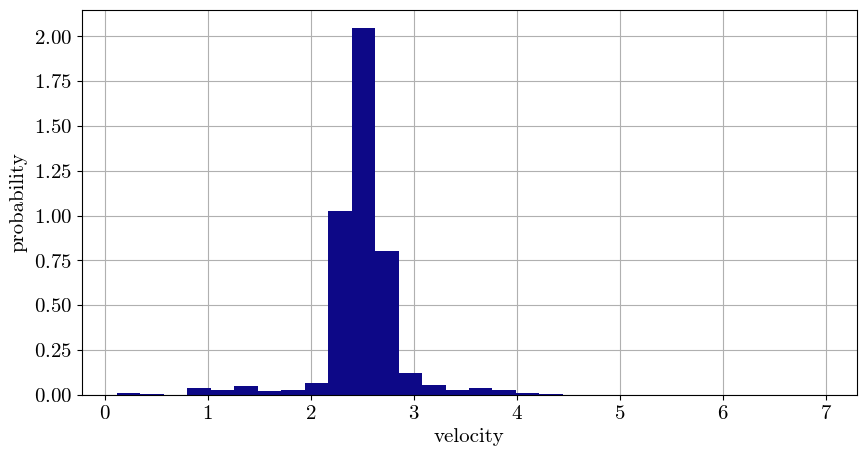

In [4]:
plt.figure(1)
plt.hist(v_first, weights = prob_first, bins = 30, density = True, color=color[0], label = 'first frame')
plt.xlabel('velocity')
plt.ylabel('probability')
plt.grid(True)


Plottando tutti frame insieme vediamo che la distribuzione delle velocità evolve dalla delta verso alla distribuzione di Maxwell-Boltzman.

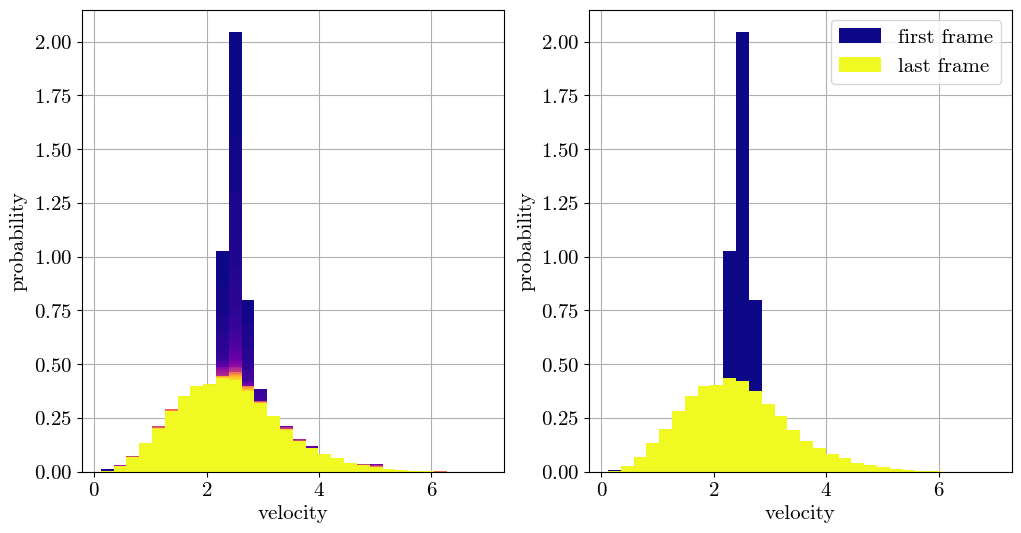

In [5]:
plt.figure(1, figsize=(12,6))
plt.subplot(1,2,1)
for i in range(frames):
    plt.hist(v[i*30:(i+1)*30], weights = prob[i*30:(i+1)*30], bins= 30, density = True, color = color[i])
#plt.errorbar(v,prob,err, ecolor= 'violet' ,color='purple', linewidth = 1)
plt.xlabel('velocity')
plt.ylabel('probability')
plt.grid(True)
#plt.hist(v_last, weights = prob_last, label = 'last frame')


plt.figure(1)
plt.subplot(1,2,2)
plt.hist(v_first, weights = prob_first, bins = 30, density = True, color=color[0], label = 'first frame')
plt.hist(v_last,  weights = prob_last, bins = 30, density = True, color=color[-1], label = 'last frame')
plt.xlabel('velocity')
plt.ylabel('probability')
plt.legend()
plt.grid(True)

Facciamo un fit della distribuzione ottenuta con la curva della distribuzione di Maxwell-Boltzmann tenedo come parametro del fit la temperatura $T$. Otteniamo che la temperatura è pari a $2.2$ che è la temperatura di equilibrio del sistema come si può vedere anche nel grafico dell'ultimo punto dell'esercizio (04.3).

T =  2.2390769553657583 ± [0.05240839]


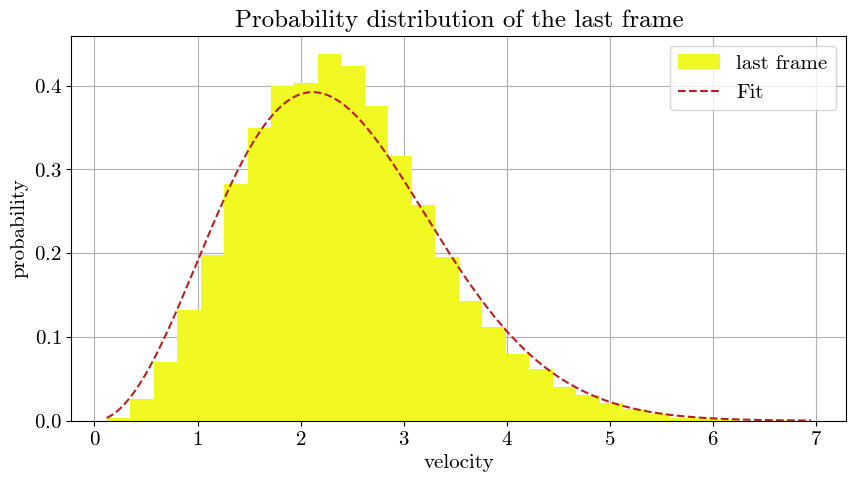

In [22]:
def probability(x, T):
    return 2 * x**2 * np.exp((-x**2)/(2*T)) /(np.sqrt(2*np.pi*(T**3)))
# T è la temperatura
# Calcolo dell'istogramma (i dati da fittare)
counts, bin_edges = np.histogram(v_last, weights=prob_last, bins=30, density=True)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

# Fit della curva
popt, pcov = curve_fit(probability, bin_centers, counts, p0=[1])
perr = np.sqrt(np.diag(pcov))
T_fit = popt[0]
print("T = ", T_fit, "±", perr )

# Plot
plt.figure(1)
plt.hist(v_last, weights=prob_last, density=True, bins=30, color=color[-1], label='last frame')
plt.xlabel('velocity')
plt.ylabel('probability')
plt.title('Probability distribution of the last frame')
plt.grid(True)

# Curva fittata
x_fit = np.linspace(min(v_last), max(v_last), 500)
y_fit = probability(x_fit, *popt)
plt.plot(x_fit, y_fit, '--', label='Fit', color='firebrick')

plt.legend()
plt.show()


### Exercise 04.3

Starting from the final state of an **equilibrated** MD simulation of the system in Exercise 04.2, by changing the direction of time (e.g. by inverting the final velocities, i.e. ... ), try to return back to the very low entropic initial configuration of Exercise 04.2. Is this possible? (for example, one can monitor the behavior of the average **potential energy** and the average **temperature** in **each block** as a function of time going **in both directions**. Show some picture and comment on what you find in your jupyter-notebook.

#### Soluzione 04.3
___

Per invertire le velocità delle particelle non ha senso invertire direttemante il valore della velocità perchè la velocità viene calcolata passo per passo e non viene utilizzata nell'algoritmo di Verlet. Dato che nell'algoritmo di Verlet si utilizzano le posizioni delle particelle al tempo $t$ e al tempo $t-dt$ per invertire la direzione del tempo invertiamo i valori delle posizioni $(x_{new} = x(t)$ e $x_{old} = x(t-dt))$. 

Facciamo una simulazione con $100$ blocchi e $1000$ passi per blocco alla fine della quale vengono salvate le posizioni raggiunge e quelle dell'istante appena precedente. Facciamo ripartire la simulazione con `_restart` a 1 e usiamo come input le configuarazioni finali raggiunte nella simulazione precedente, ma invertite, in questo modo abbiamo invertito $x_{new}$ e $x_{old}$.

Grafichiamo l'energia potenziale e la temperatura per il percorso _forward_ e _backward_ e osserviamo che invertendo l'asse dei tempi non si raggiunge il valore iniziale.\
Quando torna indietro il sistema per un primo tratto ripercorre gli stessi valori che aveva del processo _forward_, ma dopo un certo numero di blocchi inizia a non tornare più esattamente indietro. Questo comportamneto è dovuto al fatto che l'algoritmo di Verlet è _time-reversible_, ma è comunque un'approssimazione perche deriva da uno sviluppo di Taylor troncato al secondo ordine, uindi dopo un certo numero di passi l'errore diventa importante è il processo non è più reversibile.

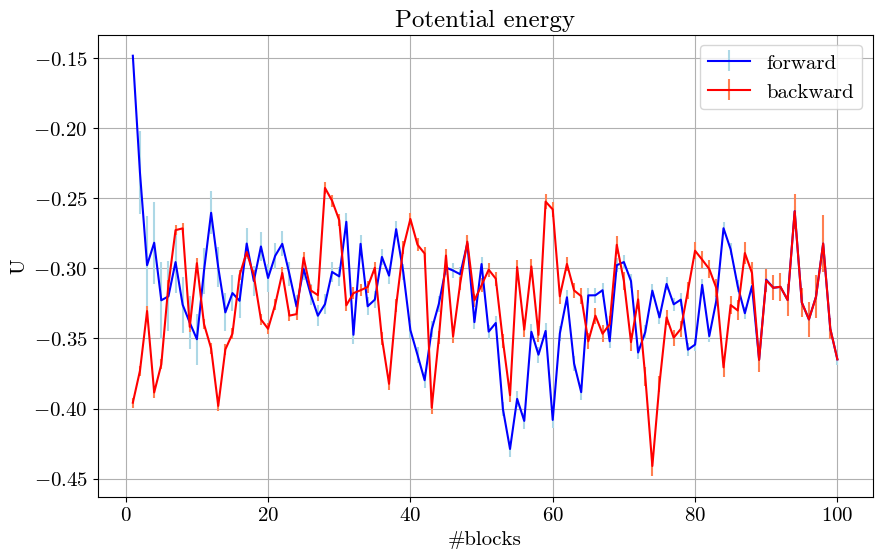

In [ ]:
temp_for = np.loadtxt("NSL_SIMULATOR/OUTPUT_FORWARD/potential_energy.dat")
x = temp_for[:,0]
y = temp_for[:,1]
err = temp_for[:,3]
temp_back = np.loadtxt("NSL_SIMULATOR/OUTPUT_BACKWARD/potential_energy.dat")
x_b = temp_back[:,0]
y_b = temp_back[:,1]
err_b = temp_back[:,3]

plt.figure(1,figsize=(10, 6))

plt.errorbar(x,y, err, color ='blue', ecolor = 'lightblue', label = 'forward')
plt.errorbar(x_b,y_b[::-1], err_b[::-1], color ='red', ecolor = 'coral', label = 'backward')

plt.legend()
plt.title("Potential energy")
plt.ylabel('U')
plt.xlabel('#blocks')
plt.grid(True)

plt.show()

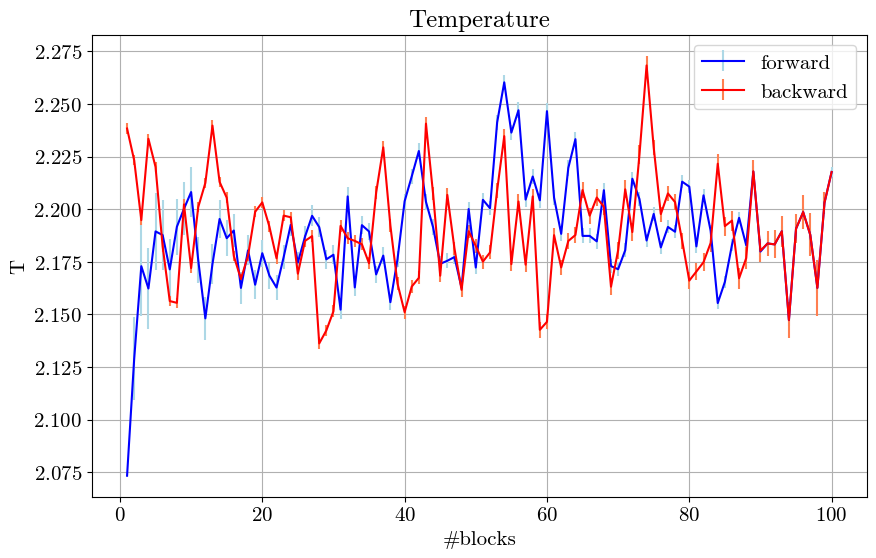

In [14]:
temp_for = np.loadtxt("NSL_SIMULATOR/OUTPUT_FORWARD/temperature.dat")
x = temp_for[:,0]
y = temp_for[:,1]
err = temp_for[:,3]
temp_back = np.loadtxt("NSL_SIMULATOR/OUTPUT_BACKWARD/temperature.dat")
x_b = temp_back[:,0]
y_b = temp_back[:,1]
err_b = temp_back[:,3]

plt.figure(1,figsize=(10, 6))
plt.errorbar(x,y, err, color ='blue', ecolor = 'lightblue', label = 'forward')
plt.errorbar(x_b,y_b[::-1], err_b[::-1], color ='red', ecolor = 'coral', label = 'backward')

plt.legend()
plt.title('Temperature')
plt.ylabel("T")
plt.xlabel('#blocks')
plt.grid(True)

plt.show()